In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import pandas as pd

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18,
                     "xtick.minor.top":True, "ytick.minor.right":True,
                     "xtick.minor.visible": True,
                     "ytick.minor.visible": True})

In [3]:
# defining color palette for plotting
palette = {"low":"olive", "high":"salmon", 
           "difference":"#2C1D11", "difference2":"#464646"
          }    
        

# Import data

In [4]:
# to import data via individual snapshots
# low = {}
# high = {}

# for snap in range(100):
#     if snap == 48:
#         continue
    
#     low[str(snap)] = {} 
#     high[str(snap)] = {}
    
#     # low-mass pairs
#     f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_{snap}.hdf5",'r')
#     for key, val in f.items():
#         low[str(snap)][key] = np.array(val)
#     f.close()
    
#     # high-mass pairs
#     g = h5py.File(f"{paths.path_data}big-bad/massive_orbitdata_{snap}.hdf5",'r')
#     for key, val in g.items():
#         high[str(snap)][key] = np.array(val)
#     g.close()

# h = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
# convert = {}
# for key, val in h.items():
#     convert[key] = np.array(val)
# h.close()

In [5]:
# to import all pair and unique pair catalogs

low_all = {}
high_all = {}

    
# low-mass pairs
f = h5py.File(f"{paths.path_data}hail-mary/all_orbits.hdf5",'r')
for key, val in f.items():
    low_all[key] = np.array(val)
f.close()
    
# high-mass pairs
g = h5py.File(f"{paths.path_data}big-bad/all_orbits_massive.hdf5",'r')
for key, val in g.items():
    high_all[key] = np.array(val)
g.close()

# conversion between snapshot-redshift-time
h = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in h.items():
    convert[key] = np.array(val)
h.close()


In [6]:
convert['Redshift'][0]

20.046490988807516

# Count unique pairs


## load data

In [7]:
low_keys = low_all['PairKey']
high_keys = high_all['PairKey']

low_unique = np.unique(low_keys)
high_unique = np.unique(high_keys)

In [8]:
print(f"Number of total low mass orbits: {len(low_keys)}")
print(f"Number of unique low mass orbits: {len(low_unique)}")



Number of total low mass orbits: 71429
Number of unique low mass orbits: 22213


In [9]:
print(f"Number of total high mass orbits: {len(high_keys)}")
print(f"Number of unique high mass orbits: {len(high_unique)}")


Number of total high mass orbits: 20824
Number of unique high mass orbits: 3039


# Plot: Number of unique orbits vs. z

### Load data<font color="red"> YOU MUST RUN THIS 


In [10]:
# import unique pair catalogs

low = {}
high = {}

    
# low-mass pairs
f = h5py.File(f"{paths.path_data}hail-mary/unique_orbits.hdf5",'r')
for key, val in f.items():
    low[key] = np.array(val)
f.close()
    
# high-mass pairs
g = h5py.File(f"{paths.path_data}big-bad/unique_orbits_massive.hdf5",'r')
for key, val in g.items():
    high[key] = np.array(val)
g.close()

# conversion between snapshot-redshift-time
h = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in h.items():
    convert[key] = np.array(val)
h.close()


## test at one snapshot

In [11]:
# goal: to find the number of pairs at snapshot 40 that HAVE YET TO MERGE and are POST INFALL

# post infall means that the infall snapshot must be = or prior to 40
postinfall_at_40 = low['InfallSnapshot'] <= 40

# pre-merger means the merger snapshot must be after 40 OR be a non-merger
merge_later = low['MergeSnapshot'] > 40
non_mergers = low['MergeSnapshot'] == -1

unmerged_at_40 = merge_later|non_mergers

In [12]:
np.count_nonzero(postinfall_at_40&unmerged_at_40)

6574

## all snapshots

In [13]:
# calculate the above for all snapshots

low_counts = []

for snap in convert['Snapshot']:
    # post infall means that the infall snapshot must be = or prior to 40
    postinfall_at_snap = low['InfallSnapshot'] <= snap

    # pre-merger means the merger snapshot must be after 40 OR be a non-merger
    merge_later = low['MergeSnapshot'] > snap
    non_mergers = low['MergeSnapshot'] == -1

    unmerged_at_snap = merge_later|non_mergers

    postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
    count = np.count_nonzero(postinfall_unmerged)
    
    postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
    count_merge = np.count_nonzero(postinfall_willmerge)

    low_counts.append([count,count_merge])
    
low_counts = np.array(low_counts)

In [14]:
# verify that the count for snap 40 is the same as the test case
low_counts[40]

array([6574, 5787])

In [15]:
# calculate above for all snapshots

high_counts = []

for snap in convert['Snapshot']:
    # post infall means that the infall snapshot must be = or prior to 40
    postinfall_at_snap = high['InfallSnapshot'] <= snap

    # pre-merger means the merger snapshot must be after 40 OR be a non-merger
    merge_later = high['MergeSnapshot'] > snap
    non_mergers = high['MergeSnapshot'] == -1

    unmerged_at_snap = merge_later|non_mergers

    postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
    count = np.count_nonzero(postinfall_unmerged)
    
    postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
    count_merge = np.count_nonzero(postinfall_willmerge)

    high_counts.append([count,count_merge])
    
high_counts = np.array(high_counts)


## pair count data from pears
*note: was using this to plot the number of counts of major pairs, but it was getting too confusing to refer to this dataset in addition to the other orbit-data set, so not going to show this*

In [16]:
# f = h5py.File(f"{paths.path_home}pears/plots/paper1/plotdata/counts.hdf5",'r')
# counts = f[f"10 Realizations"]

# pears_low = {}
# for key,val in counts['dwarf'].items():
#     pears_low[key] = np.array(val)

# pears_high = {}
# for key,val in counts['massive'].items():
#     pears_high[key] = np.array(val)

# f.close()

## make pears equiv data from orbs
*note: was using this to plot the number of counts of major pairs, but it was getting too confusing to refer to this dataset in addition to the other orbit-data set, so not going to show this*

In [17]:
# # to import data via individual snapshots
# low_snap = {}

# for snap in range(100):
#     if snap == 48:
#         continue
    
#     low_snap[str(snap)] = {} 
    
#     # low-mass pairs
#     f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_{snap}.hdf5",'r')
#     for key, val in f.items():
#         low_snap[str(snap)][key] = np.array(val)
#     f.close()

In [18]:
# l40 = low_snap['40']

In [19]:
# post = l40['InfallSnapshot'] <= 40
# later = l40['MergeSnapshot'] > 40
# non = l40['MergeSnapshot'] == -1

# un = later|non

# p_un = post & un # includes will merge & won't merge
# p_later = post & later # includes will merge & won't merge


# print(np.count_nonzero(p_un),np.count_nonzero(p_later))

In [20]:
# f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_40.hdf5",'r')
# infallsnap = f['InfallSnapshot']
# mergesnap = f['MergeSnapshot']


# # post infall means that the infall snapshot must be = or prior to 40
# postinfall_at_snap = infallsnap <= 40

# # pre-merger means the merger snapshot must be after 40 OR be a non-merger
# merge_later = f['MergeSnapshot'] > 40
# non_mergers = f['MergeSnapshot'] == -1

# f.close()

# unmerged_at_snap = merge_later|non_mergers


# postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
# count = np.count_nonzero(postinfall_unmerged)

# postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
# count_merge = np.count_nonzero(postinfall_willmerge)



In [21]:
# # calculate above for all snapshots

# low_counts_snap = []

# for snap in convert['Snapshot']:
#     if snap == 48:
#         low_counts_snap.append([np.nan,np.nan])
#         continue

#     f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_{snap}.hdf5",'r')
    
#     infallsnap = np.array(f['InfallSnapshot'])
#     mergesnap = np.array(f['MergeSnapshot'])
    
#     # post infall means that the infall snapshot must be = or prior to 40
#     postinfall_at_snap = infallsnap <= snap

#     # pre-merger means the merger snapshot must be after 40 OR be a non-merger
#     merge_later = mergesnap > snap
#     non_mergers = mergesnap == -1
    
#     f.close()

#     unmerged_at_snap = merge_later|non_mergers

#     postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
#     count = np.count_nonzero(postinfall_unmerged)
    
#     postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
#     count_merge = np.count_nonzero(postinfall_willmerge)

#     low_counts_snap.append([count,count_merge])
        
    
# low_counts_snap = np.array(low_counts_snap)

In [22]:
# # calculate above for all snapshots

# high_counts_snap = []

# for snap in convert['Snapshot']:
#     if snap == 48:
#         high_counts_snap.append([np.nan,np.nan])
#         continue

#     f = h5py.File(f"{paths.path_data}big-bad/massive_orbitdata_{snap}.hdf5",'r')
    
#     infallsnap = np.array(f['InfallSnapshot'])
#     mergesnap = np.array(f['MergeSnapshot'])
    
#     # post infall means that the infall snapshot must be = or prior to 40
#     postinfall_at_snap = infallsnap <= snap

#     # pre-merger means the merger snapshot must be after 40 OR be a non-merger
#     merge_later = mergesnap > snap
#     non_mergers = mergesnap == -1
    
#     f.close()

#     unmerged_at_snap = merge_later|non_mergers

#     postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
#     count = np.count_nonzero(postinfall_unmerged)
    
#     postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
#     count_merge = np.count_nonzero(postinfall_willmerge)

#     high_counts_snap.append([count,count_merge])
        
    
# high_counts_snap = np.array(high_counts_snap)

In [24]:
# low_counts_snap[40]

## Make plot

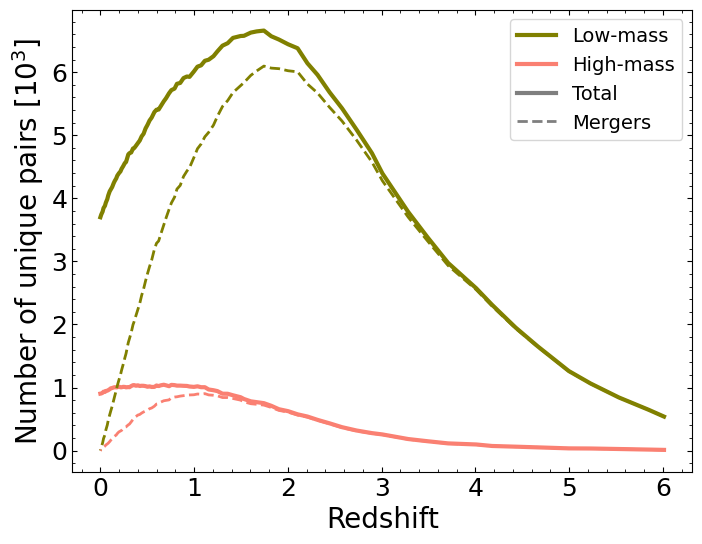

In [26]:
fig,ax = plt.subplots(figsize=(8,6))

ls_all = "solid"
ls_merge = "dashed"
ls_snap = "dotted"

lw_all = 3
lw_merge = 2
lw_snap = 1

# - unique pairs - # 
redshifts = convert["Redshift"]
redshift_mask = redshifts < 6.2

low_all = low_counts[:,0]
low_merge = low_counts[:,1]

high_all = high_counts[:,0]
high_merge = high_counts[:,1]

plot_red = redshifts[redshift_mask]

plot_low_all = low_all[redshift_mask]
plot_low_merge = low_merge[redshift_mask]

plot_high_all = high_all[redshift_mask]
plot_high_merge = high_merge[redshift_mask]

plt.plot(plot_red, plot_low_all/1000, label='Low-mass', color=palette['low'], lw=lw_all)
plt.plot(plot_red, plot_high_all/1000, label='High-mass', color=palette['high'], lw=lw_all)

plt.plot(plot_red, plot_low_merge/1000, color=palette['low'], lw=lw_merge, linestyle=ls_merge)
plt.plot(plot_red, plot_high_merge/1000, color=palette['high'], lw=lw_merge, linestyle=ls_merge)

# - plot labels - # 
plt.plot(0,0,label='Total',color="tab:grey",lw=lw_all)
plt.plot(0,0,label='Mergers',linestyle=ls_merge,color="tab:grey",lw=lw_merge)

plt.legend(fontsize=14)
# plt.title("Number of unique pairs")
plt.xlabel("Redshift")
plt.ylabel(r"Number of unique pairs $[10^3]$")
plt.savefig("../../plots/bet-on-it/6_paircount.png",bbox_inches='tight')
plt.show()


#### previous vers

NameError: name 'orbs_lw' is not defined

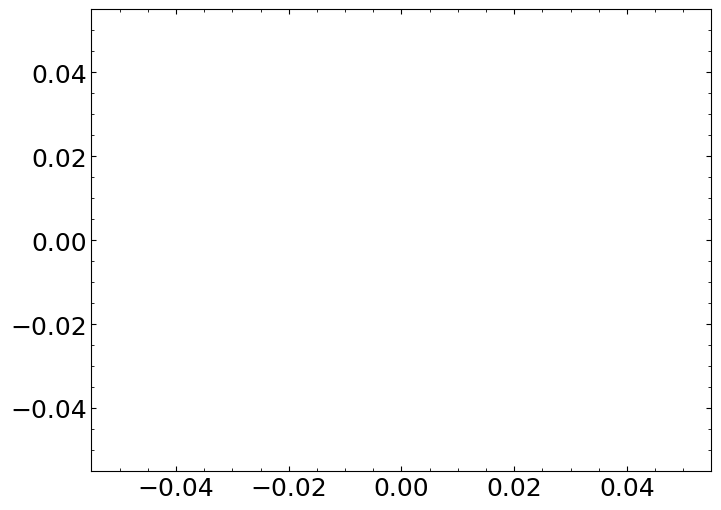

In [58]:
fig,ax = plt.subplots(figsize=(8,6))

ls_all = "solid"
ls_merge = "dashed"
ls_snap = "dotted"

lw_all = 3
lw_merge = 2
lw_snap = 1

# - plot labels - # 
plt.plot(0,0,label='Unique',color="tab:grey",lw=lw_all)
plt.plot(0,0,label='Unique Mergers',linestyle=ls_merge,color="tab:grey",lw=lw_merge)
plt.plot(0,0,label='Snapshot-selected',linestyle=ls_snap,color="tab:grey",lw=lw_snap)

# - unique pairs - # 
redshifts = convert["Redshift"]
redshift_mask = redshifts < 6.2

low_all = low_counts[:,0]
low_merge = low_counts[:,1]

high_all = high_counts[:,0]
high_merge = high_counts[:,1]

plot_red = redshifts[redshift_mask]

plot_low_all = low_all[redshift_mask]
plot_low_merge = low_merge[redshift_mask]

plot_high_all = high_all[redshift_mask]
plot_high_merge = high_merge[redshift_mask]

plt.plot(plot_red, plot_low_all, label='Low mass', color=palette['low'], lw=orbs_lw)
plt.plot(plot_red, plot_high_all, label='High-mass', color=palette['high'], lw=orbs_lw)

plt.plot(plot_red, plot_low_merge, color=palette['low'], lw=lw_merge, linestyle=ls_merge)
plt.plot(plot_red, plot_high_merge, color=palette['high'], lw=lw_merge, linestyle=ls_merge)

# - number selected at snapshot - #
redshift_mask[48] = False

plot_red = redshifts[redshift_mask]

plot_low_snap = low_counts_snap[:,0][redshift_mask]
pot_high_snap = high_counts_snap[:,0][redshift_mask]

plt.plot(plot_red, plot_low_snap, color=palette['low'],linestyle=ls_snap,lw=lw_snap)
plt.plot(plot_red, pot_high_snap, color=palette['high'],linestyle=ls_snap,lw=lw_snap)


plt.legend(fontsize=14)
# plt.title("Number of unique pairs")
plt.xlabel("Redshift")
plt.ylabel("Number of pairs")
plt.savefig("../../plots/bet-on-it/6_paircount.png",bbox)
plt.show()


# Plot: Merger fraction vs. z

In [77]:
# - unique pairs - # 
redshifts = convert["Redshift"]
redshift_mask = redshifts < 6.2

low_all = low_counts[:,0]
low_merge = low_counts[:,1]

high_all = high_counts[:,0]
high_merge = high_counts[:,1]

plot_red = redshifts[redshift_mask]

nonzero_low = np.where(low_all == 0, np.nan, low_all)
nonzero_high = np.where(high_all == 0, np.nan, high_all)

plot_low_frac = (low_merge / nonzero_low)[redshift_mask]
plot_high_frac = (high_merge / nonzero_high)[redshift_mask]

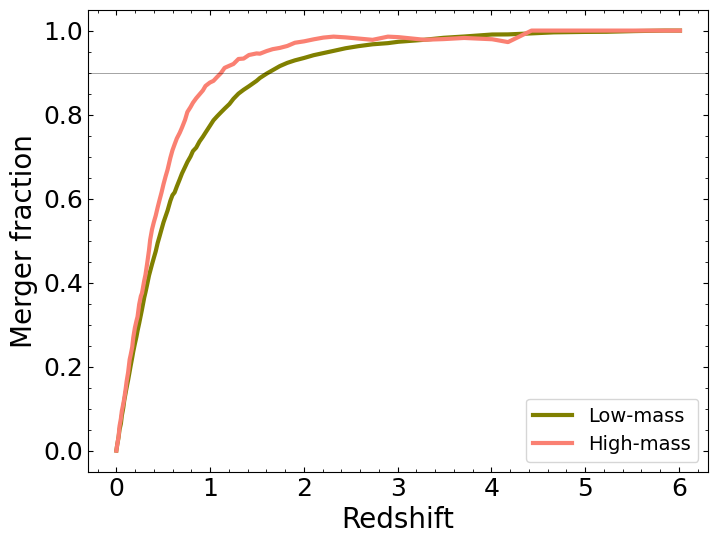

In [104]:
fig,ax = plt.subplots(figsize=(8,6))

ls_all = "solid"
ls_merge = "dashed"

lw_all = 3
lw_merge = 2

plt.plot(plot_red, plot_low_frac, label='Low-mass', color=palette['low'], lw=lw_all)
plt.plot(plot_red, plot_high_frac, label='High-mass', color=palette['high'], lw=lw_all)

plt.legend(fontsize=14)
plt.xlabel("Redshift")
plt.ylabel(r"Merger fraction")

plt.axhline(0.9, color='black', lw=0.5, alpha=0.5)
# plt.axvline(1.1, ymin=0, ymax=0.86,color=palette['high'], lw=2, linestyle='dotted')
# plt.axvline(1.6, ymin=0, ymax=0.86,color=palette['low'], lw=2, linestyle='dotted')

plt.savefig("../../plots/bet-on-it/6_mergerfraction.png",bbox_inches='tight')
plt.show()


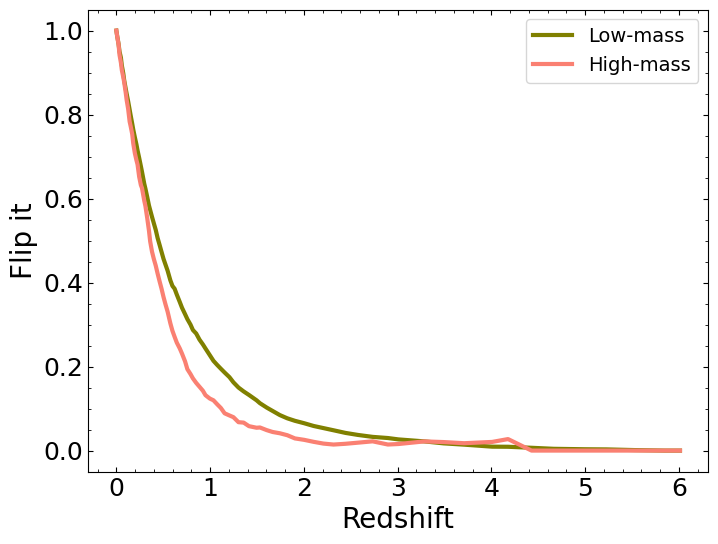

In [84]:
fig,ax = plt.subplots(figsize=(8,6))

ls_all = "solid"
ls_merge = "dashed"

lw_all = 3
lw_merge = 2

plt.plot(plot_red, 1-plot_low_frac, label='Low-mass', color=palette['low'], lw=lw_all)
plt.plot(plot_red, 1-plot_high_frac, label='High-mass', color=palette['high'], lw=lw_all)

plt.legend(fontsize=14)
plt.xlabel("Redshift")
plt.ylabel(r"Flip it")
# plt.savefig("../../plots/bet-on-it/6_paircount.png",bbox_inches='tight')
plt.show()


### comparison between snapshot-selected and orbit selected

In [74]:
# - unique pairs - # 
redshifts = convert["Redshift"]
redshift_mask = redshifts < 6.2

low_all = low_counts[:,0]
low_merge = low_counts[:,1]

high_all = high_counts[:,0]
high_merge = high_counts[:,1]

plot_red = redshifts[redshift_mask]

nonzero_low = np.where(low_all == 0, np.nan, low_all)
nonzero_high = np.where(high_all == 0, np.nan, high_all)

plot_low_frac = (low_merge / nonzero_low)[redshift_mask]
plot_high_frac = (high_merge / nonzero_high)[redshift_mask]

In [75]:
dat_massive = pd.read_csv('../../data/big-bad/highmass_merger_fraction.csv',names=np.array(["Snapshot","Fraction"]))
dat_low = pd.read_csv('../../data/hail-mary/merger_fraction.csv',names=np.array(["Snapshot","Fraction"]))


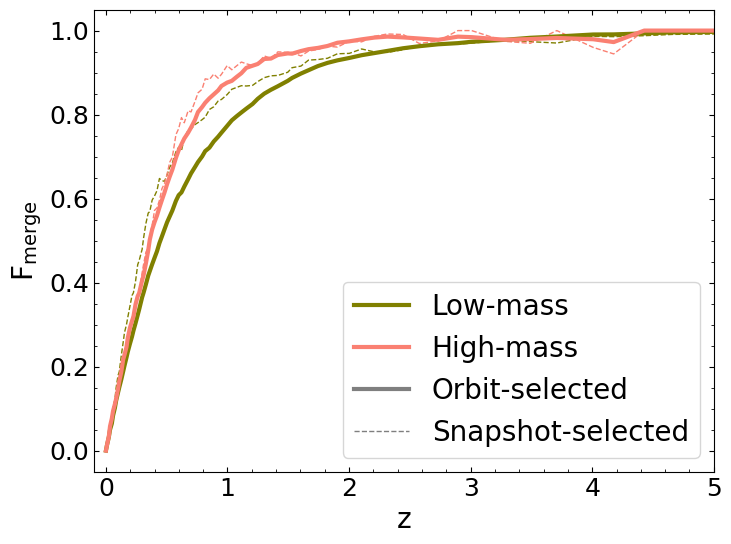

In [80]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(convert['Redshift'],dat_low['Fraction'],color=palette['low'],lw=1,linestyle='dashed')
ax.plot(convert['Redshift'],dat_massive['Fraction'],color=palette['high'],lw=1,linestyle='dashed')

plt.plot(plot_red, plot_low_frac, label='Low-mass', color=palette['low'], lw=lw_all)
plt.plot(plot_red, plot_high_frac, label='High-mass', color=palette['high'], lw=lw_all)

plt.plot(0,0,label='Orbit-selected',color="tab:grey",lw=lw_all)
plt.plot(0,0,label='Snapshot-selected',linestyle='dashed',color="tab:grey",lw=1)

ax.set_xlim(-0.1,5)
ax.set_xlabel(r"z")
ax.set_ylabel(r"$\rm F_{merge}$")
ax.legend()
# plt.savefig("../../plots/bet-on-it/1_fmerge_comp.png")
plt.show()
